In [20]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [32]:
from src.auxiliar_functions import AuxFunctions

In [22]:
df_data = pd.read_excel("../raw_data/viability_raw_data.xlsx")
df_data.head()

,Enzyme,Treatment,Viability
0,Asparaginase,0.0,100.000000
1,Asparaginase,0.0,100.000000
2,Asparaginase,0.0,100.000000
3,Asparaginase,0.5,102.024291
4,Asparaginase,0.5,129.554656


In [30]:
df_data = df_data.copy()
df_data["Enzyme"] = df_data["Enzyme"].astype(str).str.strip()
df_data["Treatment"] = pd.to_numeric(df_data["Treatment"], errors="coerce")
df_data["Viability"] = pd.to_numeric(df_data["Viability"], errors="coerce")
df_data = df_data.dropna(subset=["Enzyme", "Treatment", "Viability"])

# Canonical order for treatments
treat_order = [0.0, 0.5, 0.7, 0.9]
present_treats = [t for t in treat_order if t in set(df_data["Treatment"].unique())]
if len(present_treats) < 2:
    raise ValueError("Not enough distinct treatment levels found.")

df_data["Treatment"] = pd.Categorical(df_data["Treatment"], categories=present_treats, ordered=True)

# Optional: choose an enzyme order (edit as you wish)
enzyme_order = [
    "Arginine deiminase",
    "Asparaginase",
    "Glutaminase",
    "Glycine oxidase",
    "Serine deaminase",
]
present_enzymes = list(df_data["Enzyme"].unique())
enzyme_order = [e for e in enzyme_order if e in present_enzymes] + [e for e in present_enzymes if e not in enzyme_order]

# Global style (paper-friendly)
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
})


In [31]:
summary = (
    df_data.groupby(["Enzyme", "Treatment"], as_index=False)
           .agg(
               mean_viability=("Viability", "mean"),
               sd_viability=("Viability", "std"),
               n=("Viability", "size"),
           )
           .sort_values(["Enzyme", "Treatment"])
)

summary.head()

,Enzyme,Treatment,mean_viability,sd_viability,n
0,Arginine deiminase,0.0,100.000000,0.000000,3
1,Arginine deiminase,0.5,93.522267,5.263158,3
2,Arginine deiminase,0.7,86.627907,11.627907,3
3,Arginine deiminase,0.9,33.734940,4.703427,3
4,Asparaginase,0.0,100.000000,0.000000,3


In [33]:
letters_df = AuxFunctions.compute_letters_per_enzyme(df_data, alpha=0.05, adjust="holm", present_treats=present_treats)
letters_df.head() if not letters_df.empty else "No letters produced."


,Enzyme,Treatment,Letters
0,Arginine deiminase,0.0,a
1,Arginine deiminase,0.5,a
2,Arginine deiminase,0.7,a
3,Arginine deiminase,0.9,b
5,Asparaginase,0.0,a


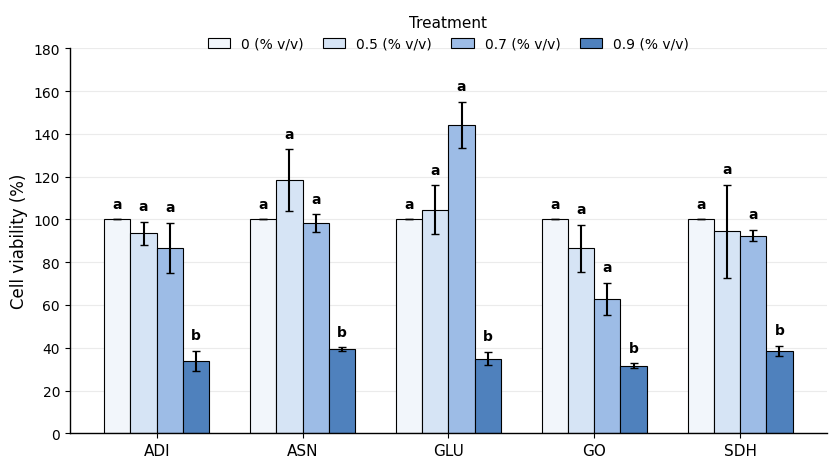

In [ ]:
# ============================================================
# Bar plots with Dunn letters, short enzyme labels
# ============================================================

# Pastel blue palette (treatment levels)
pastel_blue = {
    0.0: "#F2F6FB",  # very light blue
    0.5: "#D6E4F5",  # light blue
    0.7: "#9DBCE6",  # medium blue
    0.9: "#4F81BD",  # deeper blue
}

# Enzyme order + abbreviations
enzyme_order = [
    "Arginine deiminase",
    "Asparaginase",
    "Glutaminase",
    "Glycine oxidase",
    "Serine deaminase",
]

enzyme_abbrev = {
    "Arginine deiminase": "ADI",
    "Asparaginase": "ASN",
    "Glutaminase": "GLU",
    "Glycine oxidase": "GO",
    "Serine deaminase": "SDH",
}

enzymes = enzyme_order
x_labels = [enzyme_abbrev[e] for e in enzymes]

treatments = list(df_data["Treatment"].cat.categories)
n_groups = len(treatments)

# Reindex summary to desired order
sum_plot = summary.set_index(["Enzyme", "Treatment"]).reindex(
    pd.MultiIndex.from_product([enzymes, treatments], names=["Enzyme", "Treatment"])
).reset_index()

x = np.arange(len(enzymes))
bar_width = 0.18 if n_groups >= 4 else 0.22

fig_w = max(8.5, 1.35 * len(enzymes))
fig_h = 4.8
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# --- Bars + error bars ONLY (no replicate dots)
for i, t in enumerate(treatments):
    t_float = float(t)

    sub = sum_plot[sum_plot["Treatment"] == t].set_index("Enzyme").reindex(enzymes)
    means = sub["mean_viability"].values
    sds = sub["sd_viability"].values

    offsets = (i - (n_groups - 1) / 2) * bar_width
    xpos = x + offsets

    ax.bar(
        xpos,
        means,
        width=bar_width,
        yerr=sds,
        capsize=3,
        edgecolor="black",
        linewidth=0.8,
        color=pastel_blue.get(t_float, "#CCCCCC"),
        label=f"{t_float:g} (% v/v)",
        zorder=2
    )

# --- Dunn letters above bars
if not letters_df.empty:
    letter_map = {(r["Enzyme"], float(r["Treatment"])): r["Letters"] for _, r in letters_df.iterrows()}

    for i, t in enumerate(treatments):
        t_float = float(t)
        offsets = (i - (n_groups - 1) / 2) * bar_width
        xpos = x + offsets

        sub = sum_plot[sum_plot["Treatment"] == t].set_index("Enzyme").reindex(enzymes)
        means = sub["mean_viability"].values
        sds = sub["sd_viability"].values

        for j, enz in enumerate(enzymes):
            L = letter_map.get((enz, t_float), "")
            if L == "" or np.isnan(means[j]):
                continue

            y = means[j] + (0 if np.isnan(sds[j]) else sds[j]) + 4

            ax.text(
                xpos[j],
                y,
                L,
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
                zorder=3
            )

# --- Axes formatting (no title, no x-label)
ax.set_ylabel("Cell viability (%)")
ax.set_xlabel("")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=11)

# Y-limits with headroom
y_max = np.nanmax(sum_plot["mean_viability"] + sum_plot["sd_viability"])
ax.set_ylim(0, max(120, np.ceil((y_max + 15) / 10) * 10))

# Paper style
ax.grid(axis="y", alpha=0.25, linewidth=0.8, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend: centered and clean
ax.legend(
    title="Treatment",
    frameon=False,
    ncol=min(4, n_groups),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    handlelength=1.6,
    columnspacing=1.4
)

plt.tight_layout()
plt.show()


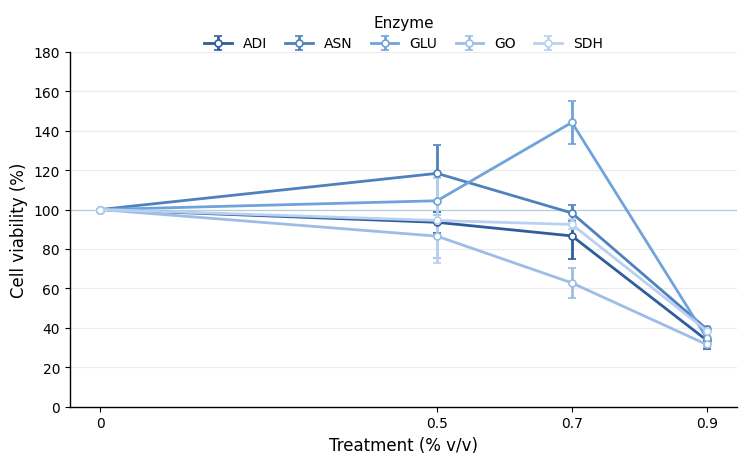

In [41]:
sum2 = (
    df_data.groupby(["Enzyme", "Treatment"], as_index=False)
           .agg(mean_viability=("Viability", "mean"),
                sd_viability=("Viability", "std"),
                n=("Viability", "size"))
)

# Canonical order (same as before)
treat_order = [0.0, 0.5, 0.7, 0.9]
present_treats = [t for t in treat_order if t in set(sum2["Treatment"].unique())]
present_treats = sorted(present_treats)

enzyme_order = [
    "Arginine deiminase",
    "Asparaginase",
    "Glutaminase",
    "Glycine oxidase",
    "Serine deaminase",
]
enzyme_abbrev = {
    "Arginine deiminase": "ADI",
    "Asparaginase": "ASN",
    "Glutaminase": "GLU",
    "Glycine oxidase": "GO",
    "Serine deaminase": "SDH",
}

enzymes = [e for e in enzyme_order if e in set(sum2["Enzyme"].unique())]

# --- Blue pastel palette (consistent "family"), one shade per enzyme
# (Still “blue”, but distinct enough for 5 curves)
enzyme_blue = {
    "Arginine deiminase": "#2F5D9B",  # deep blue
    "Asparaginase":       "#4F81BD",  # medium-deep
    "Glutaminase":        "#6FA3D9",  # mid
    "Glycine oxidase":    "#9DBCE6",  # light-mid
    "Serine deaminase":   "#B9D1F0",  # very light (still visible with edge)
}

# Style
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.linewidth": 1.0,
})

fig, ax = plt.subplots(figsize=(7.6, 4.8))

# Baseline at 100% (control)
ax.axhline(100, linewidth=1.0, alpha=0.25)

for enz in enzymes:
    d = sum2[sum2["Enzyme"] == enz].copy()
    # Ensure treatment order
    d = d.set_index("Treatment").reindex(present_treats).reset_index()

    x = d["Treatment"].astype(float).values
    y = d["mean_viability"].values
    yerr = d["sd_viability"].values

    ax.errorbar(
        x, y, yerr=yerr,
        marker="o",
        markersize=5,
        linewidth=2.0,
        capsize=3,
        color=enzyme_blue.get(enz, "#4F81BD"),
        markerfacecolor="white",      # clean, print-friendly
        markeredgewidth=1.2,
        markeredgecolor=enzyme_blue.get(enz, "#4F81BD"),
        label=enzyme_abbrev.get(enz, enz),
        zorder=3
    )

# Axes labels
ax.set_ylabel("Cell viability (%)")
ax.set_xlabel("Treatment (% v/v)")

ax.set_xticks(present_treats)
ax.set_xticklabels([f"{t:g}" for t in present_treats])

# Limits with headroom
y_max = np.nanmax(sum2["mean_viability"] + sum2["sd_viability"])
ax.set_ylim(0, max(120, np.ceil((y_max + 15) / 10) * 10))

# Grid + spines
ax.grid(axis="y", alpha=0.25, linewidth=0.8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend: move outside plot area, centered, 1 row
ax.legend(
    title="Enzyme",
    frameon=False,
    ncol=len(enzymes),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.14),
    columnspacing=1.3,
    handlelength=2.0
)

plt.tight_layout()
plt.show()

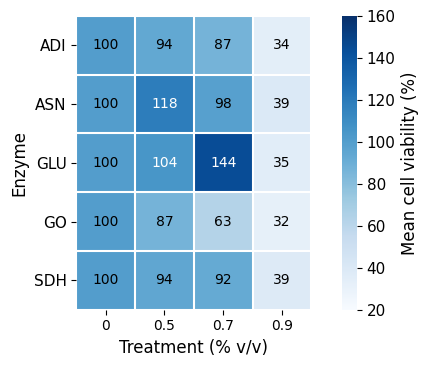

In [48]:
enzymes = [e for e in enzyme_order if e in set(df_data["Enzyme"].unique())]

heat = (
    df_data.groupby(["Enzyme", "Treatment"], as_index=False)
          .agg(mean_viability=("Viability", "mean"))
)

mat = (heat.pivot(index="Enzyme", columns="Treatment", values="mean_viability")
           .reindex(index=enzymes, columns=present_treats))

mat.index = [enzyme_abbrev.get(e, e) for e in mat.index]

# --- Nature-like styling
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 11,
    "axes.linewidth": 0.8,
})

# Fixed range for consistency across figures
# You can change to (0, 160) if you want it aligned with your bar/curve y-axis.
vmin, vmax = 20, 160

# Use a clean sequential colormap (blue family). "Blues" is classic and print-friendly.
cmap = plt.cm.Blues
norm = Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(8.6, 3.8))

# Heatmap with subtle cell boundaries (Nature-like)
im = ax.imshow(mat.values, cmap=cmap, norm=norm, aspect="equal")

# Add thin white gridlines between cells
ax.set_xticks(np.arange(-0.5, mat.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, mat.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linewidth=1.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Axis labels
ax.set_xlabel("Treatment (% v/v)")
ax.set_ylabel("Enzyme")

ax.set_xticks(np.arange(mat.shape[1]))
ax.set_xticklabels([f"{t:g}" for t in mat.columns])

ax.set_yticks(np.arange(mat.shape[0]))
ax.set_yticklabels(list(mat.index))

# Remove spines for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)

# Smart annotation: white text on dark cells, black text on light cells
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = mat.iloc[i, j]
        if np.isnan(val):
            txt = "NA"
            ax.text(j, i, txt, ha="center", va="center", fontsize=10, color="black")
            continue

        rgba = cmap(norm(val))
        # perceived luminance (0=dark, 1=light)
        luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        text_color = "white" if luminance < 0.55 else "black"

        ax.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=10, color=text_color)

# Colorbar: slim and clean
cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Mean cell viability (%)")
cbar.outline.set_linewidth(0.8)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()


### Results – Enzyme-dependent and dose-dependent effects on cell viability

Treatment with amino acid–degrading enzymes resulted in marked and enzyme-specific changes in cell viability across increasing treatment levels (0, 0.5, 0.7, and 0.9% v/v), revealing heterogeneous response patterns (Figures 1–3).

As shown in **Figure 1**, grouped bar plots highlight a clear dose-dependent reduction in viability for all enzymes at the highest treatment level (0.9% v/v), with statistically significant differences detected within each enzyme (Dunn’s post hoc test, p < 0.05). Glycine oxidase (GO) exhibited the strongest cytotoxic effect, reducing viability to approximately 32% at 0.9% v/v, while arginine deiminase (ADI), L-asparaginase (ASN), and serine deaminase (SDH) showed intermediate effects. In contrast, L-glutaminase (GLU) displayed a distinctive non-monotonic profile, with a pronounced increase in viability at 0.7% v/v followed by a sharp decline at 0.9% v/v, suggesting a biphasic or compensatory response at intermediate doses.

These trends are further resolved in **Figure 2**, which depicts dose–response curves for each enzyme across treatment levels. GO shows a consistent and progressive decline in viability, indicative of a classical dose-dependent cytotoxic effect. ADI and SDH present moderate, gradual decreases, while ASN exhibits a transient increase at 0.5% v/v before declining at higher doses. Notably, GLU demonstrates a pronounced peak at 0.7% v/v, reaching approximately 144% viability, followed by a collapse at 0.9% v/v, reinforcing the presence of a non-linear, potentially adaptive response at intermediate enzyme concentrations.

To provide an integrated overview of these patterns, **Figure 3** summarizes mean viability values in a heatmap format across enzymes and treatment levels. This representation highlights the distinct sensitivity profiles of each enzyme: GO shows a progressive decrease from 100% to 32%, ADI and SDH display intermediate sensitivity, and ASN shows modest stimulation at low dose followed by inhibition at high dose. The heatmap also emphasizes the unique behavior of GLU, which diverges from the other enzymes by inducing increased viability at 0.7% v/v before exerting cytotoxic effects at the highest concentration. Together, these data demonstrate that amino acid–degrading enzymes elicit heterogeneous, enzyme-specific response patterns, ranging from monotonic dose-dependent cytotoxicity to non-linear and biphasic effects, underscoring the complexity of metabolic vulnerabilities and adaptive responses in the system under study.
